# Mixed Momentum Strategy

Author: Nicolas Harvie 

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta
import pandas_datareader as pdr

from warnings import filterwarnings
filterwarnings('ignore')

path_intermediate = '../yilin_material/'

In [2]:
signals_master = pd.read_csv(path_intermediate + 'SignalMasterTable.csv', index_col=['Unnamed: 0'], parse_dates=['time_avail_m'])
signals_master

,permno,ret,prc,shrcd,exchcd,sicCRSP,ticker,time_avail_m,mve_c,gvkey,sicCS,tickerIBES,NYSE,bh1m
0,10000.0,NaN,-4.375000,10.0,3.0,3990.0,OMFGA,1986-01-01,1.610000e+01,NaN,NaN,NaN,0.0,-0.257143
1,10000.0,-0.257143,-3.250000,10.0,3.0,3990.0,OMFGA,1986-02-01,1.196000e+01,NaN,NaN,NaN,0.0,0.365385
2,10000.0,0.365385,-4.437500,10.0,3.0,3990.0,OMFGA,1986-03-01,1.633000e+01,NaN,NaN,NaN,0.0,-0.098592
3,10000.0,-0.098592,-4.000000,10.0,3.0,3990.0,OMFGA,1986-04-01,1.517200e+01,NaN,NaN,NaN,0.0,-0.222656
4,10000.0,-0.222656,-3.109375,10.0,3.0,3990.0,OMFGA,1986-05-01,1.179386e+01,NaN,NaN,NaN,0.0,-0.005025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879455,93436.0,0.027612,1144.760010,11.0,3.0,9999.0,TSLA,2021-11-01,1.149642e+06,184996.0,3711.0,TSLA,0.0,-0.076855
3879456,93436.0,-0.076855,1056.780029,11.0,3.0,9999.0,TSLA,2021-12-01,1.092218e+06,184996.0,3711.0,TSLA,0.0,-0.113609
3879457,93436.0,-0.113609,936.719971,11.0,3.0,9999.0,TSLA,2022-01-01,9.681319e+05,184996.0,3711.0,TSLA,0.0,-0.070768
3879458,93436.0,-0.070768,870.429993,11.0,3.0,9999.0,TSLA,2022-02-01,8.996190e+05,184996.0,3711.0,TSLA,0.0,0.238009


In [3]:
monthly_crsp = pd.read_csv(path_intermediate + 'monthlyCRSP.csv')
monthly_crsp['date'] = pd.to_datetime(monthly_crsp['date'])

In [4]:
def define_universe(file):
    # Load the list of permno values from the text file
    with open(file, 'r') as file:
        permno_list = [int(line.strip()) for line in file]

    # Filter the DataFrame based on permno values
    universe = monthly_crsp[monthly_crsp['permno'].isin(permno_list)]
    return universe

In [5]:
sp500_monthly_crsp = define_universe('sp500_permnos.txt')

***
## Firm-Age Momentum Signal

The sample period is from January 1983 to December 2001 (Zhang, 2006, 114)

In [11]:
# New signal master to create the strategy dataframe 
strat_df = monthly_crsp.copy()

In [12]:
# Convert to first of next month to eventually merge with RDQ data 
def first_day_of_next_month(date):
    next_month = date.replace(day=1) + pd.DateOffset(months=1)
    return next_month

strat_df['date'] = strat_df['date'].apply(first_day_of_next_month)

In [50]:
strat_df = pd.read_csv('./strat_df.csv', parse_dates=['date'])

In [51]:
start_date = '1983-01-01'
end_date = '2001-01-01'
strat_df = strat_df[(strat_df['date'] >= start_date) & (strat_df['date'] <= end_date)]

In [53]:
# Getting logarithmic returns for summability
strat_df['logret'] = np.log(1 + strat_df['ret'])

# Computing Cumulative Returns over past period for Momentum 
# Window is flexible, we use 12 months as per the literature
strat_df['firm_mom'] = strat_df.groupby('permno')['logret'].shift(1).rolling(window=11).sum().reset_index(level=0, drop=True)

***
## Announcement Returns

In [54]:
# Homemade CSV containing earnings data for all equities in a given timeperiod
earnings = pd.read_csv('./earnings.csv')
earnings = earnings.dropna(subset=['rdq', 'epsfxq'])

# Linking Table
ccm = pd.read_csv('../yilin_material/CCMLinkingTable.csv')

In [55]:
# Linking the tables
mm_df = strat_df.merge(ccm, on = 'permno', suffixes=('', '_y'))
mm_df.drop(mm_df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
mm_df['timeLinkStart_d'] = pd.to_datetime(mm_df['timeLinkStart_d'])
mm_df['timeLinkEnd_d'] = pd.to_datetime(mm_df['timeLinkEnd_d'])
mm_df['temp'] = 0
mm_df['temp'].loc[(mm_df['timeLinkStart_d']<=mm_df['date']) & ((mm_df['date']<=mm_df['timeLinkEnd_d']) | (mm_df['timeLinkEnd_d'].isnull()))] = 1
mm_df['temp'].value_counts(normalize=True) * 100 # check the frequency 
mm_df = mm_df.loc[mm_df['temp']==1]
mm_df.drop(columns=['temp','timeLinkStart_d','timeLinkEnd_d'], inplace=True)

In [56]:
### EARNINGS RATIO CALCULATION ###

# Taking the difference over the EPS for each asset 
earnings['diff_eps'] = earnings.groupby('gvkey')['epsfxq'].diff(4)
earnings = earnings.dropna(subset='diff_eps')

# Rolling standard deviation over the past differences 
earnings['std_diff_eps'] = earnings['diff_eps'].rolling(4).std()

# SUE 
earnings['sue'] = earnings['diff_eps'] / earnings['std_diff_eps']
earnings = earnings.dropna(subset='sue')

In [57]:
# Dates to merge
earnings['rdq'] = pd.to_datetime(earnings['rdq'])
earnings['date'] = earnings['rdq'].apply(first_day_of_next_month)
earnings.index = earnings['date']

# Resample to forward fill the measures to match dates with the DF
sue_df = earnings.groupby('gvkey')['sue'].resample('MS').first().ffill().reset_index()

In [104]:
full_df = pd.merge(mm_df, sue_df, on=['gvkey', 'date'])

In [105]:
# Some basic Filtering according to Zhang 
# Will eventually remove the values associated to those conditons
condition = ((np.abs(full_df['prc'])<5) | (full_df['tempage']<12))
full_df = full_df[~condition]

In [106]:
# Counting firm age by cumulative count of PERMNOs
# Proxy for Firm Age 
full_df.sort_values(['permno','date'], inplace=True)
full_df['tempage'] = full_df.groupby(['permno']).cumcount()+1

In [143]:
# Quantile Transform for momentum 
# Add an indicator variable which returns 1 if condition is met or zero otherwise 
# Will be helpful when we do the interaction of various conditions for the LS portfolio creation 
full_df['mom_high'] = full_df['firm_mom'] > full_df.groupby('date')['firm_mom'].transform('quantile', 0.8)
full_df['mom_low'] = full_df['firm_mom'] < full_df.groupby('date')['firm_mom'].transform('quantile', 0.2)

# Quantile Transform for age 
full_df['age_low'] = full_df['tempage'] < full_df.groupby('date')['tempage'].transform('quantile', 0.2)
full_df['age_high'] = full_df['tempage'] > full_df.groupby('date')['tempage'].transform('quantile', 0.8)

# Quantile Transform for age 
full_df['sue_low'] = full_df['sue'] < full_df.groupby('date')['sue'].transform('quantile', 0.2)
full_df['sue_high'] = full_df['sue'] > full_df.groupby('date')['sue'].transform('quantile', 0.8)

In [242]:
# Our buys 
buys = full_df[(full_df['age_low'] == True) & (full_df['mom_high'] == True) & (full_df['sue_high'] == True)][['permno', 'date', 'ret']]

# Our sells 
sells = full_df[(full_df['age_high'] == True) & (full_df['mom_low'] == True) & (full_df['sue_low'] == True)][['permno', 'date', 'ret']]

print(f'Number of position taken long over the sample: {len(buys)}')
print(f'Number of position taken short over the sample: {len(sells)}')
print(f'Total number of positions taken over the sample: {len(sells)+len(buys)}')

Number of position taken long over the sample: 857
Number of position taken short over the sample: 760
Total number of positions taken over the sample: 1617


In [243]:
# Fitting the dates with no returns 
index_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Create the Series
buy_full = pd.Series(buys.groupby('date')['ret'].mean(), name='ret')
sell_full = pd.Series(sells.groupby('date')['ret'].mean(), name='ret')

# Reindex the series to have a common set of indices
buy_full = buy_full.reindex(index_dates, fill_value=0)
sell_full = sell_full.reindex(index_dates, fill_value=0)

# Subtract the two Series
LS = buy_full - sell_full

In [244]:
# Benchmarking with the FF5
FF_five_with_rf= pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1900')[0]
FF_five = FF_five_with_rf.drop(columns={'RF'}) / 100
FF_five = FF_five.loc[(FF_five.index >= start_date) & (FF_five.index <= end_date)]
FF_five.index = FF_five.index.to_timestamp()

In [245]:
# Benchmarking with SP500
sp500_rets = pd.read_csv('./sp500_rets.csv')
sp500_rets['MthCalDt'] = pd.to_datetime(sp500_rets['MthCalDt'])
sp500_rets['MthCalDt'] = sp500_rets['MthCalDt'].apply(first_day_of_next_month)
sp500_rets = sp500_rets.set_index('MthCalDt')
sp500_rets = sp500_rets.loc[(sp500_rets.index >= start_date) & (sp500_rets.index <= end_date)]

In [246]:
Y = LS
X = sm.add_constant(sp500_rets.iloc[:, 1])

model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     6.818
Date:                Thu, 17 Aug 2023   Prob (F-statistic):            0.00966
Time:                        13:45:24   Log-Likelihood:                 113.27
No. Observations:                 217   AIC:                            -222.5
Df Residuals:                     215   BIC:                            -215.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0471      0.011      4.193      0.0

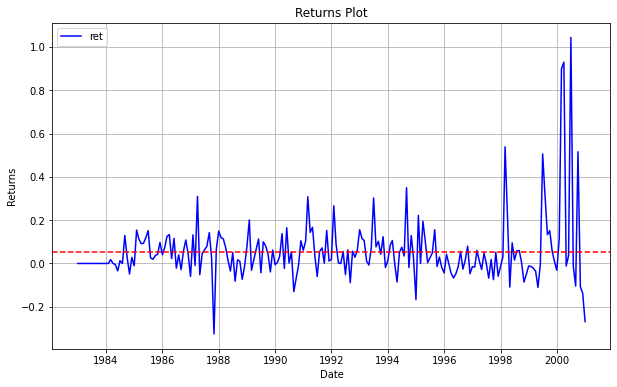

In [247]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(result, linestyle='-', color='b', label='ret')  # Customize plot style

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns Plot')
plt.legend()
plt.axhline(result.mean(), color='red', ls='--')


# Show the plot
plt.grid(True)
plt.show()